In [2]:
!pip install yfinance
!pip install torchsummary

     ---------------------------------------- 0.0/60.3 kB ? eta -:--:--
     --------------------------------- ------ 51.2/60.3 kB 1.3 MB/s eta 0:00:01
     -------------------------------------- 60.3/60.3 kB 538.6 kB/s eta 0:00:00
     ---------------------------------------- 0.0/112.2 kB ? eta -:--:--
     ---------------------------------- --- 102.4/112.2 kB 3.0 MB/s eta 0:00:01
     -------------------------------------- 112.2/112.2 kB 1.1 MB/s eta 0:00:00
  Using cached multitasking-0.0.11-py3-none-any.whl (8.5 kB)
  Using cached torchsummary-1.5.1-py3-none-any.whl (2.8 kB)


In [4]:
import os
import random
import numpy as np
import yfinance as yf
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
from matplotlib import pyplot as plt
%matplotlib inline

SEED = 8
# random.seed(SEED)
# np.random.seed(SEED)

# Data preprocessing

In [5]:
# download data from yfinance
stocks = ['GOOG','MSFT']
start_date  = "2022-01-01"
end_date  = "2022-12-31"
df = yf.download(stocks, start=start_date, end=end_date)['Adj Close']
df.head()

[*********************100%***********************]  2 of 2 completed


,GOOG,MSFT
Date,,
2022-01-03,145.074493,330.092255
2022-01-04,144.416504,324.432098
2022-01-05,137.653503,311.977875
2022-01-06,137.550995,309.512634
2022-01-07,137.004501,309.670410


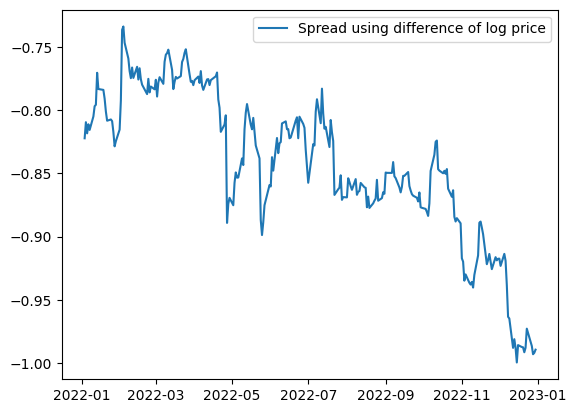

In [6]:
# Calculate the spread between the two assets
spread = np.log(df[stocks[0]]) - np.log(df[stocks[1]])

plt.plot(spread, label='Spread using difference of log price')
plt.legend()
plt.show()

# Feature engineering

In [7]:
# Define additional features
asset1_returns = np.log(df[stocks[0]]).diff()
asset2_returns = np.log(df[stocks[1]]).diff()
spread_ma5 = spread.rolling(5).mean()
asset1_volatility = asset1_returns.rolling(20).std()
asset2_volatility = asset2_returns.rolling(20).std()

In [8]:
# Combine the features into a single DataFrame
X = pd.DataFrame({'Asset1Returns': asset1_returns,
                  'Asset2Returns': asset2_returns,
                  'SpreadMA5': spread_ma5,
                  'Asset1Volatility': asset1_volatility,
                  'Asset2Volatility': asset2_volatility})
X = X.fillna(0)
y = spread

In [9]:
# Split the data into training and test sets
train_size = int(len(spread) * 0.8)
train_X = X[:train_size]
test_X = X[train_size:]
train_y = y[:train_size]
test_y = y[train_size:]

In [10]:
test_X.head()

,Asset1Returns,Asset2Returns,SpreadMA5,Asset1Volatility,Asset2Volatility
Date,,,,,
2022-10-19,-0.010908,-0.008506,-0.848473,0.019570,0.023562
2022-10-20,0.002390,-0.001396,-0.848459,0.019536,0.023467
2022-10-21,0.009406,0.024966,-0.851326,0.019354,0.023983
2022-10-24,0.014576,0.020967,-0.855048,0.019545,0.024385
2022-10-25,0.018856,0.013697,-0.858130,0.019759,0.024470


# Modeling training

In [17]:
# SVM
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

svm_model = SVR(kernel='linear')
svm_model.fit(train_X, train_y)
train_pred = svm_model.predict(train_X)
print("training rmse: ", np.sqrt(mean_squared_error(train_y, train_pred)))
test_pred = svm_model.predict(test_X)
print("test rmse: ", np.sqrt(mean_squared_error(test_y, test_pred)))


training rmse:  0.039616024799279656
test rmse:  0.12296536629715764


In [20]:
import torch

def score_fn(model, type="non_neural_net"):
    # Generate predicted spread using the SVM model
    if type == "non_neural_net":
        test_pred = model.predict(test_X)
    else:
        test_pred = model(torch.Tensor(test_X.values)).detach().numpy()
    # Calculate z-score of the actual and predicted spread
    zscore = (spread - test_pred.mean()) / test_pred.std()
    # set the threshold values for entry and exit signals
    entry_threshold = 2.0
    exit_threshold = 1.0
    # initialize the daily positions to be zeros
    stock1_position = pd.Series(data=0, index=zscore.index)
    stock2_position = pd.Series(data=0, index=zscore.index)
    # generate daily entry and exit signals for each stock
    for i in range(1, len(zscore)):
        # zscore<-2 and no existing long position for stock 1
        if zscore[i] < -entry_threshold and stock1_position[i-1] == 0:
            stock1_position[i] = 1 # long stock 1
            stock2_position[i] = -1 # short stock 2
        # zscore>2 and no existing short position for stock 2
        elif zscore[i] > entry_threshold and stock2_position[i-1] == 0:
            stock1_position[i] = -1 # short stock 1
            stock2_position[i] = 1 # long stock 2
        # -1<zscore<1
        elif abs(zscore[i]) < exit_threshold:
            stock1_position[i] = 0 # exit existing position
            stock2_position[i] = 0
        # -2<zscore<-1 or 1<zscore<2
        else:
            stock1_position[i] = stock1_position[i-1] # maintain existing position
            stock2_position[i] = stock2_position[i-1]
    
    # Calculate the returns of each stock
    stock1_returns = (np.exp(test_X['Asset1Returns']) * stock1_position.shift(1)).fillna(0)
    stock2_returns = (np.exp(test_X['Asset2Returns']) * stock2_position.shift(1)).fillna(0)
    # calculate the total returns of the strategy
    total_returns = stock1_returns + stock2_returns
    cumulative_returns = (1 + total_returns).cumprod()
    return cumulative_returns[-1]

In [21]:
score_fn(svm_model)

1.1437469086512755

In [22]:
# random forest
from sklearn.ensemble import RandomForestRegressor

# Create random forest regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model on the training and test set
rf_model.fit(train_X, train_y)
train_pred = rf_model.predict(train_X)
print("training rmse: ", np.sqrt(mean_squared_error(train_y, train_pred)))
test_pred = rf_model.predict(test_X)
print("test rmse: ", np.sqrt(mean_squared_error(test_y, test_pred)))

training rmse:  0.005625908084513008
test rmse:  0.07334794579910063


In [23]:
score_fn(rf_model)

0.9129383305697463

In [24]:
# feed forward neural network
# Convert data to PyTorch tensors
train_X_ts = torch.Tensor(train_X.values)
train_y_ts = torch.Tensor(train_y).view(-1, 1)
test_X_ts = torch.Tensor(test_X.values)
test_y_ts = torch.Tensor(test_y).view(-1, 1)

In [25]:
import torch.nn as nn

# Define the neural network model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(train_X.shape[1], 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x



In [26]:
from torchsummary import summary

# Create an instance of the neural network model
nn_model = Net()
# print the summary of the customized neural network
summary(nn_model, input_size=(1, train_X.shape[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 64]             384
              ReLU-2                [-1, 1, 64]               0
            Linear-3                [-1, 1, 32]           2,080
              ReLU-4                [-1, 1, 32]               0
            Linear-5                 [-1, 1, 1]              33
Total params: 2,497
Trainable params: 2,497
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


In [27]:
# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(nn_model.parameters(), lr=0.001)

# Train the model
for epoch in range(100):
    optimizer.zero_grad()
    outputs = nn_model(train_X_ts)
    loss = criterion(outputs, train_y_ts)
    loss.backward()
    optimizer.step()

    # Print the loss for every 10 epochs
    if epoch % 10 == 0:
        print("Epoch {}, Loss: {:.4f}".format(epoch, loss.item()))

# evaluate the model on the training and testing set
train_pred = nn_model(train_X_ts).detach().numpy()
print("training rmse: ", np.sqrt(mean_squared_error(train_y_ts, train_pred)))
test_pred = nn_model(test_X_ts).detach().numpy()
print("test rmse: ", np.sqrt(mean_squared_error(test_y_ts, test_pred)))

Epoch 0, Loss: 0.6959
Epoch 10, Loss: 0.4035
Epoch 20, Loss: 0.1764
Epoch 30, Loss: 0.0405
Epoch 40, Loss: 0.0037
Epoch 50, Loss: 0.0084
Epoch 60, Loss: 0.0052
Epoch 70, Loss: 0.0031
Epoch 80, Loss: 0.0032
Epoch 90, Loss: 0.0028
training rmse:  0.04996793
test rmse:  0.04633622


In [28]:
score_fn(nn_model, type="nn")

1.0466949332310145